# HW3: OLS Model

In [20]:
import pandas as pd

# Read the csv files
x_train_scale = pd.read_csv('x_train_scale.csv')
y_train_scale = pd.read_csv('y_train_scale.csv')

In [21]:
# Show the first 5 rows of the dataframes
print("x_train_scale:")
print(x_train_scale.head())
print("\ny_train_scale:")
print(y_train_scale.head())

x_train_scale:
   subject#       age  sex  test_time  Jitter(%)  Jitter(Abs)  Jitter:RAP  \
0         6 -0.198540    0  -1.638719   0.619703     0.740882    0.805863   
1        40  2.290131    1   0.655123  -0.298646    -0.402497   -0.371813   
2        42 -0.424783    0   1.200335  -0.401872    -0.334106   -0.355812   
3        20  0.253946    0  -1.517513  -0.341360    -0.450510   -0.269406   
4         4  1.045796    0   0.280279   0.011030    -0.013089    0.060215   

   Jitter:PPQ5  Jitter:DDP   Shimmer  Shimmer(dB)  Shimmer:APQ3  Shimmer:APQ5  \
0     0.477598    0.805846  0.386256     0.327007      0.627476      0.221878   
1    -0.324201   -0.370755  0.008842    -0.054711      0.000760      0.096563   
2    -0.302748   -0.356888 -0.303740    -0.384378     -0.273194     -0.258995   
3    -0.283977   -0.270483 -0.366642    -0.349676     -0.345998     -0.333344   
4    -0.026543    0.061270  1.407744     1.424449      1.646735      1.797604   

   Shimmer:APQ11  Shimmer:DDA      

## OLS model with motor_UPDRS

### Fit the OLS Model

In [22]:
# pip install statsmodels

In [23]:
# Do simple linear regression (OLS):
import statsmodels.api as sm

# Drop column "subject#" and "test_time" from the independent variable matrix
X = x_train_scale.drop(['subject#', 'test_time'], axis=1)

# Add a constant to the independent variable matrix
X_with_const = sm.add_constant(X)

# Use "motor_UPDRS" as the dependent variable
y = y_train_scale['motor_UPDRS']

# Fit the model
ols_model_motor = sm.OLS(y, X_with_const).fit()

# Print the summary
print(ols_model_motor.summary())

                            OLS Regression Results                            
Dep. Variable:            motor_UPDRS   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     45.64
Date:                Sun, 14 Apr 2024   Prob (F-statistic):          2.46e-149
Time:                        13:03:19   Log-Likelihood:                -6289.0
No. Observations:                4700   AIC:                         1.262e+04
Df Residuals:                    4681   BIC:                         1.274e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0504      0.017      2.940

Summary of the OLS model is shown in the table above. The result shows that the $R^2$ is quite low and that the condition number is large, which indicates strong collinearity. Therefore, the simple OLS model may not be an ideal model for our project. Anyway, we will still test the model in the following part.

### Relative Tests

Tests for normality:

$$ H_0: \text{The residuals are normally distributed}.$$

Test results for normality is shown above (Jarque-Bera test). The p-value is approximately $2.94 \times 10^{-23}$, which indicates that the normality assumption of the OLS model is violated.

Tests for heteroskedasticity:

$$ H_0: \text{The variance of the residuals is constant}.$$

In [24]:
# White test
import statsmodels.stats.diagnostic as sm_diag

_, pval, _, f_pval = sm_diag.het_white(ols_model_motor.resid, ols_model_motor.model.exog)
print("White test p-value:", pval)
print("White test F-statistic p-value:", f_pval)


White test p-value: 2.7912638602429617e-116
White test F-statistic p-value: 8.286013025490796e-136


In [25]:
# Run Breusch-Pagan test
_, pval, _, _ = sm_diag.het_breuschpagan(ols_model_motor.resid, ols_model_motor.model.exog)
print("Breusch-Pagan test p-value:", pval)


Breusch-Pagan test p-value: 5.1236541887322196e-33


Test results for heteroskedasticity are shown above (White test test and Breusch-Pagan test). The p-values of both tests is rather small, which strongly indicates heteroskedasticity within our data.

### Cross Validation to Evaluate MSE

In [26]:
import numpy as np
# import pandas as pd
# import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def perform_k_fold_cv(X, y, n_splits=5, random_state=None):
    """
    Perform K-fold cross-validation using OLS regression and compute MSE for each fold.

    Parameters:
    - X (pd.DataFrame): Independent variables with a constant included.
    - y (pd.Series): Dependent variable.
    - n_splits (int): Number of folds for the cross-validation.
    - random_state (int): Random state for reproducibility of the shuffle.

    Returns:
    - list: MSE scores for each fold.
    - float: Average MSE across all folds.
    """
    # Set up the K-Fold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    mse_scores = []  # List to store the mean squared error for each fold

    # Loop over each train/test split
    for train_index, test_index in kf.split(X):
        # Split data into training and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the OLS model
        model = sm.OLS(y_train, X_train).fit()
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        
        # Calculate MSE and append to list
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)

    # Calculate average MSE
    average_mse = np.mean(mse_scores)
    return mse_scores, average_mse

random_seed = 42

# Perform K-Fold Cross-Validation
mse_scores, average_mse = perform_k_fold_cv(X_with_const, y, random_state = random_seed)

# Print the MSE scores for each fold and the average
for i, score in enumerate(mse_scores, 1):
    print(f'MSE for fold {i}: {score}')
print(f'Average MSE: {average_mse}')


MSE for fold 1: 0.8383785591453456
MSE for fold 2: 0.8739075285483903
MSE for fold 3: 0.879135314755336
MSE for fold 4: 0.8944354468196366
MSE for fold 5: 0.8533002375091304
Average MSE: 0.8678314173555677


The estimated MSE by cross-validation is around $0.868$ (to be compared with other models).

### Plotting

In [27]:
# pip install matplotlib


We plot the prediction $\hat{y}_i$ against $y_i$.

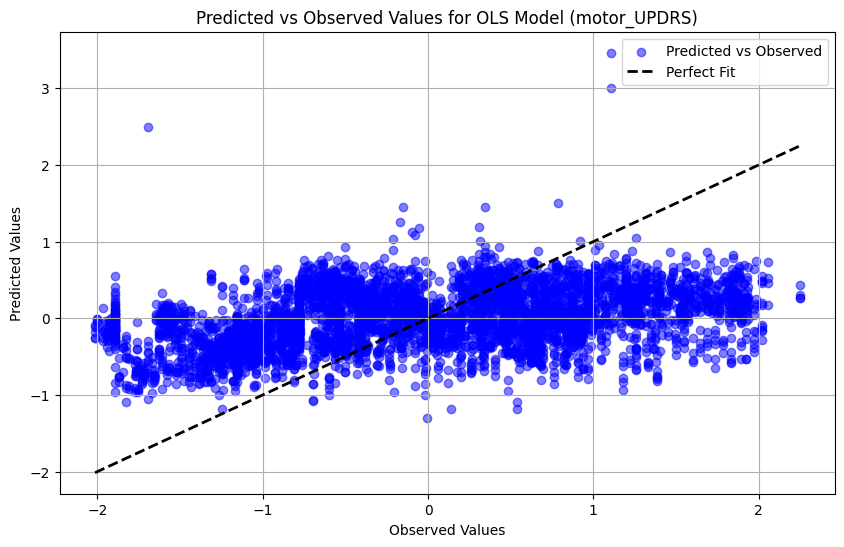

In [28]:
import matplotlib.pyplot as plt

# Generate predictions
y_pred = ols_model_motor.predict(X_with_const)

# Actual observations
y_actual = y  # This is your y_train_scale['motor_UPDRS']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_actual, y_pred, alpha=0.5, color='blue', label='Predicted vs Observed')  # Plotting the points

# Plot the line of perfect prediction
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'k--', lw=2, label='Perfect Fit')  # Line from min to max of observed

# Labeling the axes
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Observed Values for OLS Model (motor_UPDRS)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


The plot shows that the data points clearly deviate from the line of perfect fit.

## OLS model with total_UPDRS

### Fit the OLS Model

In [29]:
# Use "total_UPDRS" as the dependent variable
y = y_train_scale['total_UPDRS']

# Fit the model
ols_model_total = sm.OLS(y, X_with_const).fit()

# Print the summary
print(ols_model_total.summary())

                            OLS Regression Results                            
Dep. Variable:            total_UPDRS   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     54.11
Date:                Sun, 14 Apr 2024   Prob (F-statistic):          1.28e-176
Time:                        13:03:19   Log-Likelihood:                -6224.8
No. Observations:                4700   AIC:                         1.249e+04
Df Residuals:                    4681   BIC:                         1.261e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0872      0.017      5.157

Summary of the OLS model is shown in the table above. The result is similar to the OLS model fitted with motor_UPDRS. The $R^2$ is low and the condition number is large, which indicates strong collinearity. 

### Relative Tests

Tests for normality:

$$ H_0: \text{The residuals are normally distributed}.$$

Test results for normality is shown above (Jarque-Bera test). The p-value is approximately $1.87 \times 10^{-26}$, which indicates that the normality assumption of the OLS model is violated.

Test results for normality and autocorrelation are shown above (Jarque-Bera test and Durbin-Watson test).

Tests for heteroskedasticity:

$$ H_0: \text{The variance of the residuals is constant}.$$

In [30]:
# White test
import statsmodels.stats.diagnostic as sm_diag

_, pval, _, f_pval = sm_diag.het_white(ols_model_total.resid, ols_model_total.model.exog)
print("White test p-value:", pval)
print("White test F-statistic p-value:", f_pval)


White test p-value: 6.910923555266251e-153
White test F-statistic p-value: 5.315329492315364e-184


In [31]:
# Run Breusch-Pagan test
_, pval, _, _ = sm_diag.het_breuschpagan(ols_model_motor.resid, ols_model_motor.model.exog)
print("Breusch-Pagan test p-value:", pval)


Breusch-Pagan test p-value: 5.1236541887322196e-33


Test results for heteroskedasticity are shown above (White test test and Breusch-Pagan test). The p-values of both tests is rather small, which strongly indicates heteroskedasticity within our data.

### Cross Validation to Evaluate MSE

In [32]:
random_seed = 42

# Perform K-Fold Cross-Validation
mse_scores, average_mse = perform_k_fold_cv(X_with_const, y, random_state = random_seed)

# Print the MSE scores for each fold and the average
for i, score in enumerate(mse_scores, 1):
    print(f'MSE for fold {i}: {score}')
print(f'Average MSE: {average_mse}')

MSE for fold 1: 0.8132243692649835
MSE for fold 2: 0.8270070239370002
MSE for fold 3: 0.8229923807761838
MSE for fold 4: 0.908669746819136
MSE for fold 5: 0.8242669042682831
Average MSE: 0.8392320850131174


The estimated MSE by cross-validation is around $0.839$ (to be compared with other models).

### Plotting

We plot the prediction $\hat{y}_i$ against $y_i$.

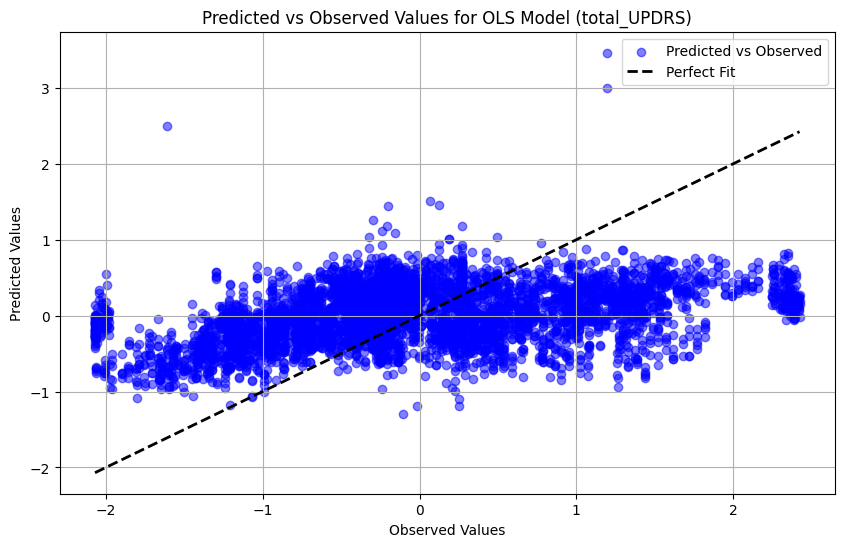

In [33]:
# import matplotlib.pyplot as plt

# Generate predictions
y_pred = ols_model_motor.predict(X_with_const)

# Actual observations
y_actual = y  # This is your y_train_scale['motor_UPDRS']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_actual, y_pred, alpha=0.5, color='blue', label='Predicted vs Observed')  # Plotting the points

# Plot the line of perfect prediction
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'k--', lw=2, label='Perfect Fit')  # Line from min to max of observed

# Labeling the axes
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Observed Values for OLS Model (total_UPDRS)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


The plot shows that the data points clearly deviate from the line of perfect fit.